In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing Necessary Libraries and Packages

In [2]:
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, Dropout, Dense, MaxPool2D,BatchNormalization,Flatten
from tensorflow.keras import Model, layers, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16 

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Glimpse of **CSV `DataFrame.`**

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/rails.csv')

In [5]:
# CHECKING THE HEAD OF THE DATAFRAME
df.head()

,class index,filepaths,labels,data set
0,0,train/Defective/131004959_171473721383413_8222...,Defective,train
1,0,train/Defective/131051004_382613492830631_1306...,Defective,train
2,0,train/Defective/131065180_999185033824671_7735...,Defective,train
3,0,train/Defective/131084537_190751489449739_2798...,Defective,train
4,0,train/Defective/131092897_149705809860659_8798...,Defective,train


In [6]:
# CHECKING FOR ANY "NAN" VALUES IN THE DATA
df.isnull().sum()

class index    0
filepaths      0
labels         0
data set       0
dtype: int64

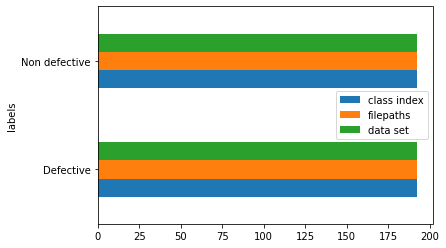

In [7]:
df.groupby('labels').count().plot.barh()

### Creating Plots to get better understanding of data

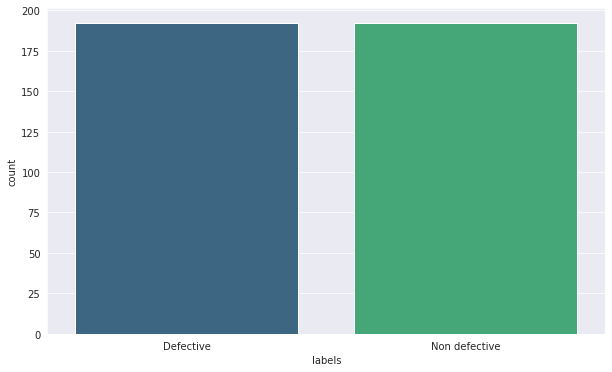

In [8]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.countplot(df['labels'],palette='viridis');
plt.savefig('Labels Count Total.svg')

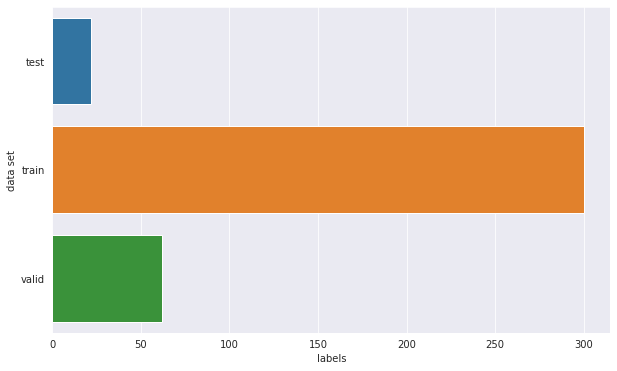

In [9]:
plt.figure(figsize=(10,6))
df_gb = df.groupby(by='data set').count()
df_gb.reset_index(inplace=True)
sns.barplot( df_gb['labels'],df_gb['data set'])
plt.savefig('Labels Count (In Each Data).svg')

### Grasping the **Labels** 

In [10]:
paths = glob.glob('/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/*')
l = len('/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/')
labels = []
for path in paths:
    labels.append(path[l:])
    
print(labels)

['Defective', 'Non defective']


### Creating a function for **`Dataset Preparation.`**

In [11]:
def dataset_preparation(path,label):
    x_train = []
    y_train = []
    path_img = glob.glob(path+'/*.jpg')
    for path in path_img:
        img = load_img(path,target_size=(150,150))
        img = img_to_array(img)
        img = img/255.0
        x_train.append(img)
        y_train.append(label)
        
    return x_train, y_train

### Plotting some Images from the Training Data

In [12]:
fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,1)
img1 = load_img("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/Defective/131004959_171473721383413_8222187747086021011_n.jpg")
img_plot = plt.imshow(img1)
ax.set_title(labels[0])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,2)
img2 = load_img("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/Non defective/IMG_20201114_100021.jpg")
img_plot = plt.imshow(img2)
ax.set_title(labels[1])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,3)
img3 = load_img("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/Non defective/IMG_20201114_100032.jpg")
img_plot = plt.imshow(img3)
ax.set_title(labels[1])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,4)
img4 = load_img("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/Defective/131051004_382613492830631_1306891331783850055_n.jpg")
img_plot = plt.imshow(img4)
ax.set_title(labels[0])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,5)
img5 = load_img("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/Defective/131065180_999185033824671_7735147288489715620_n.jpg")
img_plot = plt.imshow(img5)
ax.set_title(labels[0])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,6)
img1 = load_img("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/Defective/131084537_190751489449739_279862595635733772_n.jpg")
img_plot = plt.imshow(img1)
ax.set_title(labels[0])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,7)
img2 = load_img("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/Non defective/IMG_20201114_100044.jpg")
img_plot = plt.imshow(img2)
ax.set_title(labels[1])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,8)
img3 = load_img("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/Non defective/IMG_20201114_100046.jpg")
img_plot = plt.imshow(img3)
ax.set_title(labels[1])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,9)
img4 = load_img("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/Defective/131129946_140815574232570_8925999503657494497_n.jpg")
img_plot = plt.imshow(img4)
ax.set_title(labels[0])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,10)
img5 = load_img("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/Defective/131275810_2686956714949012_5021348409242545922_n.jpg")
img_plot = plt.imshow(img5)
ax.set_title(labels[0])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,11)
img1 = load_img("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/Defective/131348023_405054987354853_8834671660058234194_n.jpg")
img_plot = plt.imshow(img1)
ax.set_title(labels[0])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,12)
img2 = load_img("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/Non defective/IMG_20201114_100110.jpg")
img_plot = plt.imshow(img2)
ax.set_title(labels[1])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,13)
img3 = load_img("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/Non defective/IMG_20201114_100134.jpg")
img_plot = plt.imshow(img3)
ax.set_title(labels[1])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,14)
img4 = load_img("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/Defective/2007.05.16_-_002_Broken_rail_weld_-_Flickr_-_faxepl.jpg")
img_plot = plt.imshow(img4)
ax.set_title(labels[0])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,15)
img5 = load_img("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/Defective/89e8b1a9ca8c41919021f8f4faaf37f0.jpg")
img_plot = plt.imshow(img5)
ax.set_title(labels[0])
plt.grid(visible=False)
plt.savefig('Images from Dataset.svg')

Output hidden; open in https://colab.research.google.com to view.

### **Preparation** of Dataset

In [13]:
defct_train_data = dataset_preparation(path="/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/Defective",
                                       label=labels[0])
ndefct_train_data = dataset_preparation(path="/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train/Non defective",
                                        label=labels[1])

defct_test_data = dataset_preparation(path="/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/test/Defective",
                                      label=labels[0])
ndefct_test_data = dataset_preparation(path="/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/test/Non defective",label=labels[1])

defct_valid_data = dataset_preparation(path="/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/valid/Defective",
                                       label=labels[0])
ndefct_valid_data = dataset_preparation(path="/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/valid/Non defective",
                                        label=labels[1])

In [14]:
train_data = np.concatenate((defct_train_data,ndefct_train_data),axis=1)
test_data = np.concatenate((defct_test_data,ndefct_test_data),axis=1)
valid_data = np.concatenate((defct_valid_data,ndefct_valid_data),axis=1)

print(f"Shape of Training Data is {train_data.shape}.")
print(f"Shape of Testing Data is {test_data.shape}.")
print(f"Shape of Validation Data is {valid_data.shape}.")

Shape of Training Data is (2, 284).
Shape of Testing Data is (2, 22).
Shape of Validation Data is (2, 62).


### Making **Generators** for **Train**, **Test** and **Valid** Data

In [15]:
img_aug_tr = ImageDataGenerator(rescale=1.0/255)
train_gen = img_aug_tr.flow_from_directory("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/train",
                                          target_size=(150,150),
                                          class_mode='categorical',
                                          batch_size=16)

Found 299 images belonging to 2 classes.


In [16]:
img_aug_tst = ImageDataGenerator(rescale=1.0/255)
test_gen = img_aug_tst.flow_from_directory("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/test",
                                          target_size=(150,150),
                                          class_mode='categorical',
                                          batch_size=16)

Found 22 images belonging to 2 classes.


In [17]:
img_aug_vld = ImageDataGenerator(rescale=1.0/255)
valid_gen = img_aug_vld.flow_from_directory("/content/drive/MyDrive/Datasets/Railway Track Fault Dataset/Railway Track Fault Dataset.zip (Unzipped Files)/valid",
                                          target_size=(150,150),
                                          class_mode='categorical',
                                          batch_size=16)

Found 62 images belonging to 2 classes.


### Building our **CNN** Model

In [18]:
model = Sequential()

# PREPARING THE MODEL NETWORK

model.add(Conv2D(64,kernel_size=(3,3),activation='relu', input_shape=(150,150,3)))

# NORMALIZING THE LAYER
model.add(BatchNormalization())

# ADDING DROPOUT LAYER
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))

# ADDING POOLING LAYER
model.add(MaxPool2D((2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(512,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.25))

# FLATTENING CONVOLUTIONAL LAYER TO 1-D LAYER
model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.25))

# OUTPUT LAYER
model.add(Dense(2,activation='sigmoid'))

# MODEL SUMMARY
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 148, 148, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 73, 73, 64)        0

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss='BinaryCrossentropy',
             metrics=['accuracy'])

In [20]:
# USING A CALLBACK FUNCTION TO STOP OVERFITTING
earlystop = EarlyStopping(monitor='val_loss',patience=30,verbose=1,mode='min')

model.fit_generator(train_gen,epochs=160,verbose=1,callbacks=[earlystop],
                   validation_data=(valid_gen))

Epoch 1/160
19/19 [==============================] - 20s 326ms/step - loss: 1.0672 - accuracy: 0.4716 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/160
19/19 [==============================] - 2s 97ms/step - loss: 0.8401 - accuracy: 0.5084 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 3/160
19/19 [==============================] - 2s 97ms/step - loss: 0.8295 - accuracy: 0.4649 - val_loss: 0.6948 - val_accuracy: 0.5000
Epoch 4/160
19/19 [==============================] - 2s 98ms/step - loss: 0.8379 - accuracy: 0.4314 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 5/160
19/19 [==============================] - 2s 98ms/step - loss: 0.7540 - accuracy: 0.5050 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 6/160
19/19 [==============================] - 2s 100ms/step - loss: 0.7680 - accuracy: 0.5050 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 7/160
19/19 [==============================] - 2s 97ms/step - loss: 0.7404 - accuracy: 0.5318 - val_loss: 0.6945 - val_accuracy: 0.4839
Epo

### Model **Evaluation**

In [21]:
model.evaluate(train_gen,batch_size=16,verbose=1,callbacks=[earlystop])

19/19 [==============================] - 2s 101ms/step - loss: 0.5608 - accuracy: 0.6923


[0.5607972145080566, 0.692307710647583]

##### ***CNN Model got an **accuracy** of `69.23 %` and incurred a **loss** of `0.5608`.

### Predicting our Model on **Test Data**

In [22]:
predictions = model.predict(test_gen,batch_size=8,verbose=1,callbacks=[earlystop])
predictions

2/2 [==============================] - 1s 841ms/step


array([[0.6698957 , 0.26909217],
       [0.49298802, 0.4723473 ],
       [0.31705445, 0.69591266],
       [0.7396994 , 0.19537978],
       [0.8345378 , 0.13352145],
       [0.4487819 , 0.5575747 ],
       [0.84169817, 0.12391357],
       [0.70351386, 0.2386763 ],
       [0.69888866, 0.22989379],
       [0.50779015, 0.47221455],
       [0.3953974 , 0.6511877 ],
       [0.69808793, 0.23970032],
       [0.74788296, 0.19231471],
       [0.80718035, 0.15786524],
       [0.6006339 , 0.3609032 ],
       [0.25391507, 0.7441829 ],
       [0.6668937 , 0.2727362 ],
       [0.4256182 , 0.58124644],
       [0.60573494, 0.36604527],
       [0.60141844, 0.36255658],
       [0.8614594 , 0.11022609],
       [0.23955753, 0.78862876]], dtype=float32)

In [23]:
test_pred = pd.DataFrame(predictions,columns=['Test Loss','Test Accuracy'])
test_pred.head()

,Test Loss,Test Accuracy
0,0.669896,0.269092
1,0.492988,0.472347
2,0.317054,0.695913
3,0.739699,0.195380
4,0.834538,0.133521


### Data Analysis on Test Predictions

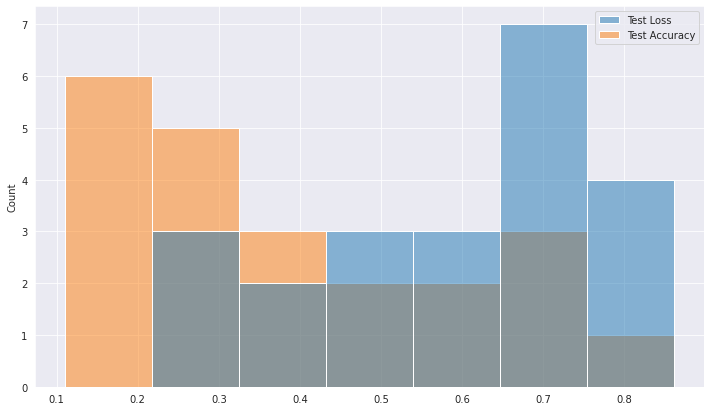

In [24]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1,1,1)
sns.histplot(test_pred);
plt.savefig('Test Prediction Count.svg')

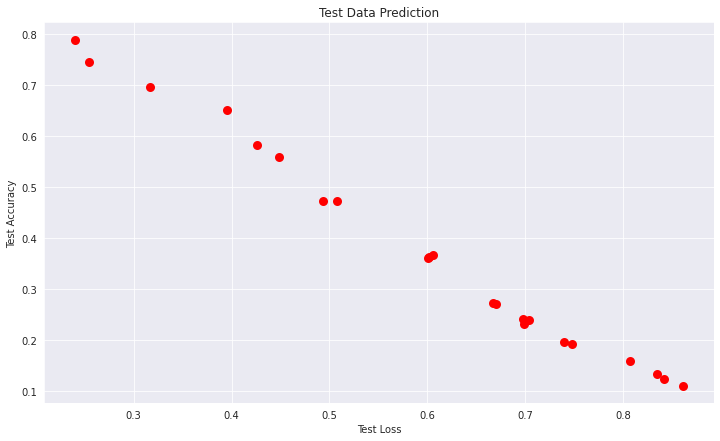

In [25]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1,1,1)
ax.scatter(test_pred['Test Loss'],test_pred['Test Accuracy'],marker='o',c='red',cmap='viridis',linewidths=3);
ax.set_title("Test Data Prediction")
ax.set_xlabel(test_pred.columns[0])
ax.set_ylabel(test_pred.columns[1])
plt.savefig('Test Prediction Plot.svg')

### SAVING THE MODEL

In [26]:
model.save('railway_track_fault_detection.h5')

In [27]:
pre_trained_model = VGG16(include_top=False,weights='imagenet',input_shape=(150,150,3))
pre_trained_model.summary()

58900480/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [28]:
def build_model():
    base = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(150,150,3)))

    base.trainable = False

    flatten = base.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(64, activation="relu")(flatten)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(2, activation="sigmoid")(bboxHead)

    model = Model(inputs=base.input, outputs=bboxHead)
    
    return model

In [29]:
model = build_model()

83697664/83683744 [==============================] - 2s 0us/step


In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

save_best = tf.keras.callbacks.ModelCheckpoint("Model.h5", monitor='loss',save_best_only=True, verbose=1)

In [31]:
model.fit_generator(train_gen,epochs=55,callbacks=[save_best],validation_data=valid_gen)

Epoch 1/55
18/19 [===========================>..] - ETA: 0s - loss: 1.6353 - accuracy: 0.6466
Epoch 1: loss improved from inf to 1.67019, saving model to Model.h5
19/19 [==============================] - 7s 193ms/step - loss: 1.6702 - accuracy: 0.6488 - val_loss: 0.7819 - val_accuracy: 0.7419
Epoch 2/55
18/19 [===========================>..] - ETA: 0s - loss: 0.9777 - accuracy: 0.7633
Epoch 2: loss improved from 1.67019 to 0.94758, saving model to Model.h5
19/19 [==============================] - 2s 90ms/step - loss: 0.9476 - accuracy: 0.7692 - val_loss: 0.8467 - val_accuracy: 0.7903
Epoch 3/55
19/19 [==============================] - ETA: 0s - loss: 0.3130 - accuracy: 0.8829
Epoch 3: loss improved from 0.94758 to 0.31300, saving model to Model.h5
19/19 [==============================] - 2s 90ms/step - loss: 0.3130 - accuracy: 0.8829 - val_loss: 0.5878 - val_accuracy: 0.7903
Epoch 4/55
18/19 [===========================>..] - ETA: 0s - loss: 0.1057 - accuracy: 0.9682
Epoch 4: loss impr

In [32]:
model.evaluate_generator(train_gen,callbacks=[earlystop],verbose=1)

19/19 [==============================] - 1s 61ms/step - loss: 7.9599e-05 - accuracy: 1.0000


[7.959942740853876e-05, 1.0]

#### ***Xception Model incurred a **loss** of **`7.96e-05`** and an **Accuracy** of **`100 %`**.

In [33]:
model_predict = model.predict(test_gen,batch_size=8,callbacks=[earlystop])
predictions_model2 = pd.DataFrame(model_predict,columns=['Test Loss','Test Accuracy'])
predictions_model2.head()

,Test Loss,Test Accuracy
0,9.862889e-02,3.259845e-07
1,1.432936e-02,6.622692e-05
2,4.576707e-03,3.994486e-06
3,1.140926e-01,2.812642e-04
4,1.309120e-09,3.120771e-03


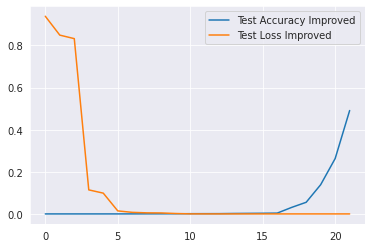

In [34]:
#PLOTTING THE TEST ACCURACY VS TEST LOSS
predictions_model2['Test Accuracy Improved'] = sorted(predictions_model2['Test Accuracy'])
predictions_model2['Test Loss Improved'] = sorted(predictions_model2['Test Loss'],reverse=True)
predictions_model2.drop(['Test Loss','Test Accuracy'],axis=1,inplace=True)
predictions_model2[['Test Accuracy Improved','Test Loss Improved']].plot()
plt.legend(bbox_to_anchor=[1,1])
plt.savefig('xception-performance.svg')

In [35]:
model.save('Track-fault-detection-xception.h5')